## Bayesian Particle Tracking

Alan Zhou

### Generative Model

Because the diffusion process follows the normal distribution, writing down a generative model is straightforward. For any given data point, the PDF for the distance a particle will travel by brownian motion is given by:

$$P(\Delta r|\theta_i) = \frac{1}{\sqrt{2\pi \beta^2}}\exp{\frac{-(\Delta r)^2}{2\beta^2}}$$

where the $\theta_i$ are the parameters of the model. These are $a$, radius of the particle, $\mu$, dynamic viscosity of the medium, $T$, temperature, and $\tau$, time constant. These show up in our above equation since $\beta$ is given by $\sqrt{6D\tau}$. And from Stokes - Einstein we know:

$$D = \frac{k_bT}{6\pi\mu a}$$

where $k_b$ is Boltzmann's constant.

### Likelihood Function

If we assume that the error term in the measurement of a position is Gaussian, we can see that for a given data point, we have (as in Gregory 4.51) the convolution of two gaussians:

$$p(Y_i|M,\theta_i,I)=\frac{1}{\sqrt{2\pi}\sqrt{\beta^2+\sigma_{i}^2}}\exp{\frac{-(y_i-m(x_i|\theta_i))^2}{2(\beta^2+\sigma_{i}^2)}}$$

where $\theta_i$ represents the parameters of the model and $\sigma_i$ is the uncertainty on the displacement measurement and is given by

$$\sigma_{i}^2 = \sigma_{m,i}^2 + \sigma_{m,i-1}^2$$

where $\sigma_j$ is the measurement uncertainty on point j.

For n data points we have a likelihood function that is just the product of n such gaussians:

$$p(\Delta r_{1,2}, \Delta r_{2,3}, ..., \Delta r_{n-1, n}|M,\theta_i,I) = \Pi_{i=1}^n p(\Delta r_{i-1,i}|M,\theta_i,I)$$

$$=(2\pi)^{-N/2}\{\Pi_{i=1}^n(\beta^2+\sigma_{i}^2)^{-1/2}\}\exp\{\sum_{i=1}^N(\frac{-(\Delta r)^2}{2(\beta^2+\sigma_{i}^2)}\}$$

As a function of the coordinate positions of each particle in the ith frame $x_i,y_i,z_i$, the likelihood function is:

$$p(D|M,\theta,I)=(2\pi)^{-N/2}\{\Pi_{i=1}^n\frac{1}{\sqrt{(\beta^2+\sigma_i^2)}}\}\exp\{\sum_{i=1}^N(-\frac{(x_i-x_{i-1})^2+(y_i-y_{i-1})^2+(z_i-z_{i-1})^2}{2(\beta^2+\sigma_i^2)}\}$$

## Analysis of Test Data:

We start by creating 3D simulated data (commented out because the data already exists in the root directory). We use values of $\sigma = 10^{-8}$, $\mu = 10^{-4}$, $a = 10^{-8}$, $T = 300K$, and 1000 steps of duration 1 second each. This gives us a value of 

$$D = \frac{k_bT}{6\pi\mu a} = 2.1973*10^{-10}$$

Our initial analysis will involve MCMC to find our 'missing' parameter D.

In [1]:
%matplotlib inline

import Bayesian_Particle_Tracking

from Bayesian_Particle_Tracking import model
from Bayesian_Particle_Tracking.model import diffusion, log_likelihood, log_posterior, log_prior
from Bayesian_Particle_Tracking.prior import JeffreysPrior, UniformPrior
from Bayesian_Particle_Tracking.generate_data import data_generation, generator
from Bayesian_Particle_Tracking import io
from Bayesian_Particle_Tracking.data_analysis import max_likelihood_estimation, MSD, Nind, sigma_var, CGW_analysis
import emcee
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/Users/alanzhou/anaconda3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
new_data = io.get_example_model('test_data.npy')

WIthe two out of three parameters known (e.g., mu and T) we can either do MCMC for just the single parameter remaining. Or we can follow the procedure in Gregory 3.8 to find $p(\theta|D,M,I)$ where $\theta$ is the Diffusion coefficient or the remaining parameter in question (since both are directly proportional to each other, finding one is the equivalent of finding the other).

In [4]:
#the model has 1 parameter; we'll use 40 walkers and 500 steps
ndim = 1
nwalkers = 20
nsteps = 500

starting_positions = [abs(10**(-10) + 1e-10*np.random.randn(ndim)) for i in range(nwalkers)]

# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[new_data])
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 6.96 s, sys: 51.3 ms, total: 7.01 s
Wall time: 7.07 s
Done


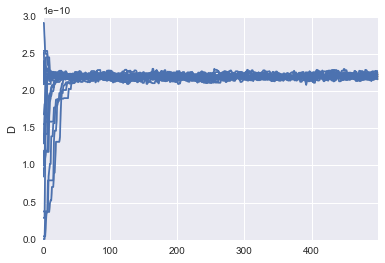

In [5]:
fig, (ax_D) = plt.subplots(1)
ax_D.set(ylabel='D')
for i in range(nwalkers):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_D)

This is a pretty fast burn in time. We'll cut out the first 50 steps.

In [6]:
samples = sampler.chain[:,50:,:]
# reshape the samples into a 1D array where the column is D
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels. 
parameter_samples = pd.DataFrame({'D': traces[0]})

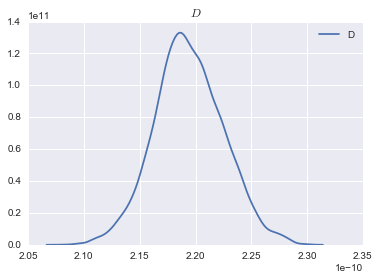

In [7]:
sns.kdeplot(parameter_samples['D'])
plt.title('$D$')

In [8]:
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

print("D = {:.3e} + {:.3e} - {:.3e}".format(q['D'][0.50], 
                                            q['D'][0.84]-q['D'][0.50],
                                            q['D'][0.50]-q['D'][0.16]))

D = 2.193e-10 + 3.249e-12 - 2.819e-12


This is really nice, and very close to what we expected. And our true value lies well within our 68% credibility interval. For larger data sets we should expect the value to converge to the true value. For a demonstration of the analysis on a larger data set, go to the tutorial notebook.

We might know the values of two out of the three parameters (usually temperature and another one) and thus would be interested in directly ascertaining the value of the third parameter.

Let's try finding our value for $a$. We generated the test data using $\mu = 10^{-4}$, $\sigma = 10^{-8}$, $T = 300$, $n_{steps} = 1000$, and $a = 10^{-8}$. So if our model works correctly, we should return $a = 10^{-8}$ after inputting our known values for the other parameters.

In [9]:
#the model has 1 parameter; we'll use 40 walkers and 500 steps
ndim = 1
nwalkers = 20
nsteps = 500

starting_positions = [abs(10**(-8) + 1e-10*np.random.randn(ndim)) for i in range(nwalkers)]

# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=[new_data],
                                kwargs = {'lower_bound': 1e-10, 'upper_bound': 1e-6, 'unknown': 'a', 'known_variables': (1e-4, 300)})
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

CPU times: user 7.95 s, sys: 95.9 ms, total: 8.05 s
Wall time: 8.34 s
Done


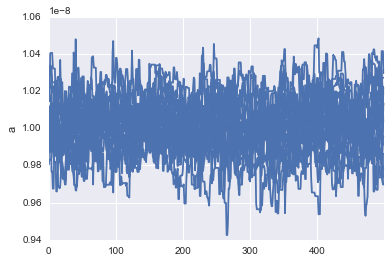

In [10]:
fig, (ax_a) = plt.subplots(1)
ax_a.set(ylabel='a')
for i in range(nwalkers):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_a)

In [11]:
samples = sampler.chain[:,100:,:]
# reshape the samples into a 1D array where the column is D
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels. 
parameter_samples = pd.DataFrame({'a': traces[0]})

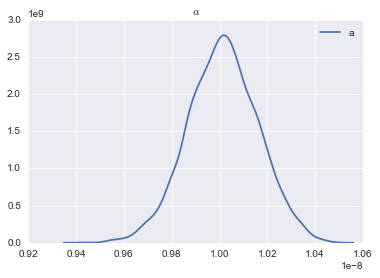

In [12]:
sns.kdeplot(parameter_samples['a'])
plt.title('$a$')

In [13]:
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

print("a = {:.3e} + {:.3e} - {:.3e}".format(q['a'][0.50], 
                                            q['a'][0.84]-q['a'][0.50],
                                            q['a'][0.50]-q['a'][0.16]))

a = 1.002e-08 + 1.450e-10 - 1.445e-10


This is about about what we expected. Of course, our value for $a$ would be more accurate with a larger data set. At the very least we see that we slightly overestimated D, so we should expect to slightly underestimate $a$ (since $D\propto \frac{1}{a}$).

Now let's try simple Maximum Likelihood Estimation:

In [3]:
D, Dbest, loglike, Dmin, Dmax = max_likelihood_estimation(new_data, -11, -9, 10000)

In [4]:
print("D = {:.4e} + {:.4e} - {:.4e}".format(Dbest, 
                                            Dmax-Dbest,
                                            Dbest-Dmin))

D = 2.1925e-10 + 3.1527e-12 - 3.0085e-12


# CGW

Compare our above methods to the CGW method.

In [33]:
msd, sigma, counter = CGW_analysis(new_data, 1000, down_sample = 1)

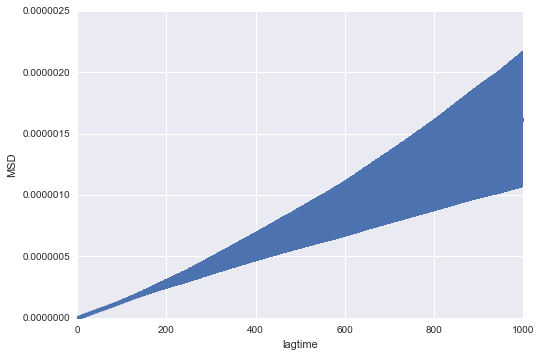

In [34]:
plt.errorbar(counter, msd, yerr = sigma, fmt = '.')
plt.xlabel('lagtime')
plt.ylabel('MSD')

In [35]:
from scipy.optimize import curve_fit

In [36]:
def f(tau,D):
    return 6*D*tau

In [37]:
popt, pcov = curve_fit(f, counter, msd, sigma = sigma)
D = popt[0]
sigma_D = np.sqrt(pcov[0])
sigma_D

array([  3.00936175e-13])

In [38]:
print("a = %.3e + %.3e - %.3e" %(D, sigma_D, sigma_D))

a = 2.253e-10 + 3.009e-13 - 3.009e-13


Much less accurate!

In [49]:
%time D, Dbest, loglike, Dmin, Dmax = max_likelihood_estimation(new_data, -11, -9, 100)

CPU times: user 73.7 ms, sys: 1.59 ms, total: 75.3 ms
Wall time: 75.4 ms


In [50]:
print("D = {:.4e} + {:.4e} - {:.4e}".format(Dbest, 
                                            Dmax-Dbest,
                                            Dbest-Dmin))

D = 2.1544e-10 + 0.0000e+00 - 0.0000e+00


In [65]:
round(log_posterior(1e-10, new_data))

86028.0

In [66]:
log_posterior(1e-6,new_data)

-inf